In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
from similarity import SimilarityPredictions
from collaborative_filtering import CollaborativeFiltering
from content_filtering import ContentFiltering

# Load Tags Data

In [3]:
#make index mapping
ratings=pd.read_csv('ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings.columns=['userId','movieId', 'rating', 'timestamp']
m_uniq=ratings.movieId.unique()
movie2idx={o:i for i,o in enumerate(m_uniq)}
with open('movie_to_idx.pkl', 'wb') as fh:
    pickle.dump(movie2idx,fh)

In [4]:
# Load index mapping 
with open('movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

In [5]:
#load tags and ratings data
#cwd = os.getcwd()
#tags = pd.read_csv("tags.csv")
tags = pd.read_csv('tags.dat',sep='::', header=None, engine='python', encoding='latin-1')
tags.columns=['userId','movieId','tag','timestamp']
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print("the tags data has {} shape".format(tags.shape))
# ratings = pd.read_csv("ratings.csv")
ratings=pd.read_csv('ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings.columns=['userId','movieId', 'rating', 'timestamp']
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

7601 unique movies in tags.csv
the tags data has (95580, 4) shape
10677 unique movies in ratings.csv


In [6]:
tags.sample(20)

,userId,movieId,tag,timestamp
85046,64633,27822,bahamas,1142346036
28948,21184,2355,Pixar,1141101836
27319,19460,33903,revolution,1163515752
21252,14598,2131,Criterion,1229104920
2420,944,1219,AFI 100,1164400552
11524,10555,906,singer,1215720951
74560,52806,1206,Stanley Kubrick,1154123913
69523,50970,6918,Apu trilogy,1176160313
31209,23032,5903,erlend's DVDs,1165082559
89524,68055,2046,Children,1186682390


In [7]:
tags.shape

(95580, 4)

In [8]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

10677 unique movies in tags.csv
(98630, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,15.0,1926,excellent!,1.215185e+09,38,5.0,1162149051
1,146.0,1926,surreal,1.193705e+09,38,5.0,1162149051
2,1751.0,1926,Jeunet,1.137525e+09,38,5.0,1162149051
3,2456.0,1926,Paris,1.163102e+09,38,5.0,1162149051
4,2456.0,1926,romance,1.163102e+09,38,5.0,1162149051


In [9]:
#map movie index for movie data
#movies = pd.read_csv("movies.csv")
movies = pd.read_csv("movies.dat", sep='::', header=None, engine='python', encoding='latin-1')
movies.columns=['movieId','title','genres']
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

10681 unique movies in movies.csv
10677 unique movies in ratings.csv
10677 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
2976,Primer (2004),Drama Mystery SciFi Thriller,92,5.0,1162165737


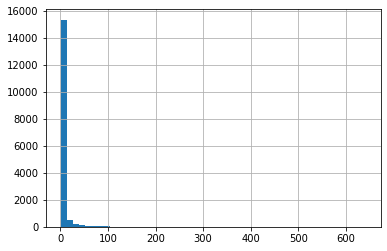

In [10]:
tags.tag.value_counts().hist(bins=50)

In [11]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 10677 unique movies


,movieId,tag
5988,5988,{based on a book Dr. Seuss based on a book ada...
5568,5568,{}
8747,8747,{campy disturbing gritty gruesome DVD-RAM VHS}
763,763,{time travel dumb but funny time travel teen e...
2075,2075,{submarine}
4923,4923,{cheerleading crime}
7082,7082,{}
6006,6006,{}
8273,8273,{}
2177,2177,{literature library vhs biting cynical satiric...


In [12]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(7)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Boomerang (1992),Comedy Romance,1,5.0,838985046,0,{dating Nudity (Topless - Brief) Can't remember},{dating Nudity (Topless - Brief) Can't remembe...
1,"Net, The (1995)",Action Crime Thriller,1,5.0,838983525,1,{computers computers internet Irwin Winkler Sa...,{computers computers internet Irwin Winkler Sa...
2,Dumb & Dumber (1994),Comedy,1,5.0,838983392,2,{Jeff Daniels Jim Carrey stupid Jim Carrey Shi...,{Jeff Daniels Jim Carrey stupid Jim Carrey Shi...
3,Outbreak (1995),Action Drama SciFi Thriller,1,5.0,838983421,3,{biology Gross disease Futuristmovies.com dise...,{biology Gross disease Futuristmovies.com dise...
4,Stargate (1994),Action Adventure SciFi,1,5.0,838983392,4,{Egypt space time travel time travel aliens an...,{Egypt space time travel time travel aliens an...
5,Star Trek: Generations (1994),Action Adventure Drama SciFi,1,5.0,838983392,5,{far future space trekie Enterprise Futuristmo...,{far future space trekie Enterprise Futuristmo...
6,"Flintstones, The (1994)",Children Comedy Fantasy,1,5.0,838984474,6,{animation remade as live action Based on a TV...,{animation remade as live action Based on a TV...


In [13]:
tags[tags['title'].str.contains("Lord of the")]

,title,genres,userId,rating,timestamp,movieId,tag,document
60,"Lord of the Rings: The Two Towers, The (2002)",Action Adventure Fantasy,3,3.5,1133570984,60,{based on a book big budget new zealand scenic...,{based on a book big budget new zealand scenic...
64,"Lord of the Rings: The Return of the King, The...",Action Adventure Fantasy,3,4.0,1133571171,64,{based on a book big budget new zealand scenic...,{based on a book big budget new zealand scenic...
798,"Lord of the Rings: The Fellowship of the Ring,...",Action Adventure Fantasy,8,3.5,1115860999,798,{based on a book big budget new zealand scenic...,{based on a book big budget new zealand scenic...
1248,"Lord of the Rings, The (1978)",Adventure Animation Children Fantasy,16,3.0,912601791,1248,{Epic based on a book high fantasy sleep aburr...,{Epic based on a book high fantasy sleep aburr...
1855,Lord of the Flies (1990),Adventure Drama Thriller,36,4.0,1049943917,1855,{based on a book island desert island feelings...,{based on a book island desert island feelings...
2741,Lord of the Flies (1963),Adventure Drama Horror Thriller,73,3.0,974327083,2741,{based on a book island library Savage Criteri...,{based on a book island library Savage Criteri...
3482,Phantasm III: Lord of the Dead (1994),Horror,139,4.0,974380943,3482,{},{} Horror
5093,"Greystoke: The Legend of Tarzan, Lord of the A...",Adventure Drama Romance,276,1.0,1070918284,5093,{cinematographer:John Alcott adapted from:auth...,{cinematographer:John Alcott adapted from:auth...


In [14]:
tags[tags['title'].str.contains("Ice")]

,title,genres,userId,rating,timestamp,movieId,tag,document
812,Ice Age (2002),Adventure Animation Children Comedy,8,4.0,1115858552,812,{talking animals animated Disney own it Maybe ...,{talking animals animated Disney own it Maybe ...
2677,"Ice Storm, The (1997)",Drama,68,5.0,945877452,2677,{Ang Lee moody Abe Ari Knoll Best Movies Ever ...,{Ang Lee moody Abe Ari Knoll Best Movies Ever ...
2906,Ice Age 2: The Meltdown (2006),Adventure Animation Comedy,82,3.0,1215146126,2906,{talking animals Animation erlend's DVDs seen ...,{talking animals Animation erlend's DVDs seen ...
4687,"Ice Harvest, The (2005)",Action Comedy Crime Thriller,215,4.0,1147232126,4687,{couldn't finish it black comedy debased Eric'...,{couldn't finish it black comedy debased Eric'...
6162,"Ice Pirates, The (1984)",Action Adventure Comedy SciFi,621,2.5,1118066209,6162,{Sucks big time! cult film dystopia robots tim...,{Sucks big time! cult film dystopia robots tim...
6817,Ice Princess (2005),Children Comedy Drama,1174,3.0,1162266093,6817,{figure skating pointless},{figure skating pointless} Children Comedy Drama
7074,Fire and Ice (1983),Animation Fantasy,1377,3.0,1026202491,7074,{Good versus evil sword and sorcery},{Good versus evil sword and sorcery} Animation...
7269,Ice Castles (1978),Drama,1541,2.0,1134333734,7269,{figure skating K movie},{figure skating K movie} Drama
8019,Ice Station Zebra (1968),Action Thriller,2215,3.0,1134599071,8019,{70mm},{70mm} Action Thriller
8168,Ice-Cold in Alex (1958),Adventure Drama War,2584,4.0,1189880684,8168,{},{} Adventure Drama War


In [15]:
#tags.query('movieId == 131').document.values
tags.query('movieId == 1127').document.values

array(["{woman French DVD hit men remade assassin atmospheric cynical harsh stylized tense visceral Nudity (Topless - Brief) Can't remember assassin assassin-in-training killer-as-protagonist murder RemakeOf:La Femme Nikita(1990) In Netflix Queue assassins remade Luc Besson Spy action assassins foreign remade ClearPlay R France Girl Power movie to see Comedy d action sexy action action crime romance thriller assassin assassins} Action Crime Romance Thriller"],
      dtype=object)

In [16]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer bad ending cinematographer:Harris Savides Robert Downey Jr. David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr based on a true story serial killer; serial killer investigation obsession unresolved Mark Ruffalo Too long 3.5 Robert Downey Jr Too long j netflix uninteresting toplist07 3.5 David Fincher owned Tumey's DVDs R bad ending long slow based on a true story Robert Downey Jr. Too long David Fincher ClearPlay R ummarti2007} Crime Drama Thriller"],
      dtype=object)

In [17]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer bad ending cinematographer:Harris Savides Robert Downey Jr. David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr based on a true story serial killer; serial killer investigation obsession unresolved Mark Ruffalo Too long 3.5 Robert Downey Jr Too long j netflix uninteresting toplist07 3.5 David Fincher owned Tumey's DVDs R bad ending long slow based on a true story Robert Downey Jr. Too long David Fincher ClearPlay R ummarti2007} Crime Drama Thriller"],
      dtype=object)

In [18]:
tags.query('movieId == 19849')

,title,genres,userId,rating,timestamp,movieId,tag,document


# TFIDF

In [19]:
#TO DO run and save tfisd matrix for autencoder with muc more features. 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(0, 1),
    min_df=0.0001,
    stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=tags.index.tolist())
print(tfidf_df.shape)
tfidf_df.head(3)

(10677, 6250)


,0,1,2,3,4,5,6,7,8,9,...,6240,6241,6242,6243,6244,6245,6246,6247,6248,6249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
tfidf.vocabulary_

{'dating': 1442,
 'nudity': 3986,
 'topless': 5649,
 'brief': 796,
 'remember': 4644,
 'comedy': 1188,
 'romance': 4780,
 'computers': 1219,
 'internet': 2904,
 'winkler': 6105,
 'sandra': 4869,
 'bullock': 848,
 'computer': 1218,
 'cracker': 1313,
 'cyber': 1391,
 'blackmail': 676,
 'intimidation': 2913,
 'hackers': 2491,
 'hacking': 2493,
 'action': 158,
 'crime': 1333,
 'thriller': 5593,
 'dennis': 1508,
 'miller': 3679,
 'diane': 1555,
 'baker': 509,
 'jeremy': 3002,
 'ken': 3124,
 'howard': 2744,
 'wendy': 6045,
 'jeff': 2994,
 'daniels': 1424,
 'jim': 3018,
 'carrey': 941,
 'stupid': 5368,
 'shit': 5061,
 'infantile': 2857,
 'funny': 2240,
 'hilarious': 2647,
 'carey': 927,
 'fantastic': 2006,
 'buddy': 838,
 'movie': 3803,
 'goofy': 2387,
 'irreverent': 2933,
 'madcap': 3447,
 'quirky': 4505,
 'raunchy': 4560,
 'silly': 5099,
 'hell': 2609,
 'dumb': 1722,
 'theater': 5562,
 'tv': 5768,
 'vhs': 5898,
 'annoying': 347,
 'sound': 5208,
 'funniest': 2239,
 'film': 2085,
 'biology': 

In [22]:
tfidf_df.to_pickle('tfidf_matrix.pkl')